In [1]:
from torch.profiler import profile, record_function, ProfilerActivity
import torch
import total_energy as te
from mala.network import TesterGraph
from mala import printout
import mala
import os
# set CUDA to highest debug mode
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

torch.cuda.device_count()

4

In [2]:
parameters = mala.Parameters()

parameters.data.data_splitting_type = "by_snapshot"
parameters.data.use_graph_data_set = True
parameters.data.n_closest_ions = 8
parameters.data.n_closest_ldos = 16
parameters.data.n_batches = 3000

parameters.running.max_number_epochs = 1
parameters.running.ldos_grid_batch_size = 300
parameters.running.mini_batch_size = 1
parameters.running.learning_rate_embedding = 0.001
parameters.running.learning_rate = 0.00001
parameters.running.trainingtype = "Adam"
parameters.running.visualisation = 1
parameters.running.weight_decay = 0.01

# ! TODO: log magnitude of weights (separately for embedding layers and for the rest)


parameters.targets.ldos_gridsize = 201
parameters.targets.ldos_gridoffset_ev = -13.5
parameters.targets.ldos_gridspacing_ev = 0.1
parameters.targets.pseudopotential_path = "/bigdata/casus/wdm/Bartek_H2/H128"

n_train = 1
n_val = 1
n_test = 1


parameters.verbosity = 2

parameters.use_gpu = True


In [3]:
train_data_handler = mala.DataHandlerGraph(parameters)
for i in range(n_train):
    train_data_handler.add_snapshot(
        f'H_snapshot{i}.pw.scf.in', f'/bigdata/casus/wdm/Bartek_H2/H128/snapshot{i}',
        f'H_snapshot{i}.out.npy', '/bigdata/casus/wdm/Bartek_H2/H128/ldos/',
        'tr', calculation_output_file=f'/bigdata/casus/wdm/Bartek_H2/H128/outputs/snapshot{i}.out'
    )
for i in range(n_train, n_train + n_val):
    train_data_handler.add_snapshot(
        f'H_snapshot{i}.pw.scf.in', f'/bigdata/casus/wdm/Bartek_H2/H128/snapshot{i}',
        f'H_snapshot{i}.out.npy', '/bigdata/casus/wdm/Bartek_H2/H128/ldos/',
        'va', calculation_output_file=f'/bigdata/casus/wdm/Bartek_H2/H128/outputs/snapshot{i}.out'
    )
train_data_handler.prepare_data(reparametrize_scaler=False)

test_data_handler = mala.DataHandlerGraph(parameters)
for i in range(n_train + n_val, n_train + n_val + n_test):
    test_data_handler.add_snapshot(
        f'H_snapshot{i}.pw.scf.in', f'/bigdata/casus/wdm/Bartek_H2/H128/snapshot{i}',
        f'H_snapshot{i}.out.npy', '/bigdata/casus/wdm/Bartek_H2/H128/ldos/',
        'te', calculation_output_file=f'/bigdata/casus/wdm/Bartek_H2/H128/outputs/snapshot{i}.out'
    )

test_data_handler.prepare_data(reparametrize_scaler=False)



No data rescaling will be performed.
No data rescaling will be performed.
Checking the snapshots and your inputs for consistency.
Consistency check successful.
Data scalers already initilized, loading data to RAM.
Build datasets.
Using GraphDataset.
Build dataset: Done.
No data rescaling will be performed.
No data rescaling will be performed.
Checking the snapshots and your inputs for consistency.
DataHandler prepared for inference. No training possible with this setup. If this is not what you wanted, please revise the input script. Validation snapshots you may have entered willbe ignored.
Consistency check successful.
Build datasets.
Using GraphDataset.
Build dataset: Done.


In [4]:
parameters.network.nn_type = "se3_transformer"
parameters.network.layer_sizes = [
    train_data_handler.input_dimension,
    64,
    train_data_handler.output_dimension
]
# Setup network and trainer.
network = mala.Network(parameters)
trainer = mala.TrainerGraph(parameters, network, train_data_handler)
trainer.train_network()
print("Training finished!")

Writing visualization output to ./mala_logging/2023-08-21-12-11-00
Validating ldos on validation data set.


  0%|          | 0/1620 [00:00<?, ?it/s]

/home/brzoza73/casus/mala-venv/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/brzoza73/casus/mala-venv/lib/python3.8/site-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


batch 1000, validation avg time: 0.006280557155609131 validation avg throughput: 47766.46284192664
Initial Guess - validation data loss:  0.002044636231881601
batch 1000, train avg time: 0.021228453636169434 train avg throughput: 14131.976127024836
training time: 34.495769023895264
Validating ldos on validation data set.


  0%|          | 0/1620 [00:00<?, ?it/s]

batch 1000, validation avg time: 0.00655819296836853 validation avg throughput: 45744.30814203847
Epoch 0: validation data loss: 0.0017200115286273722, training data loss: 0.002040474503128617
Time for epoch[s]: 45.12335014343262
Final validation data loss:  0.0017200115286273722
Training finished!


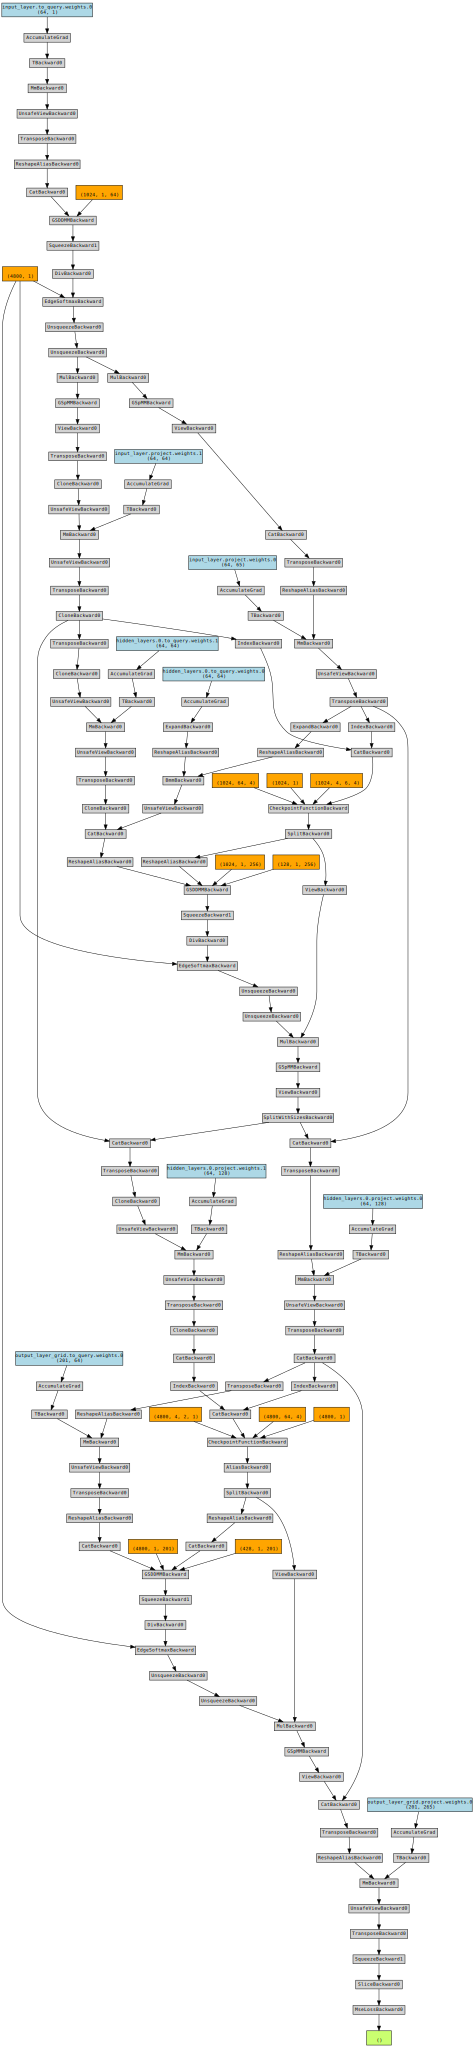

In [5]:
trainer.dots[0]

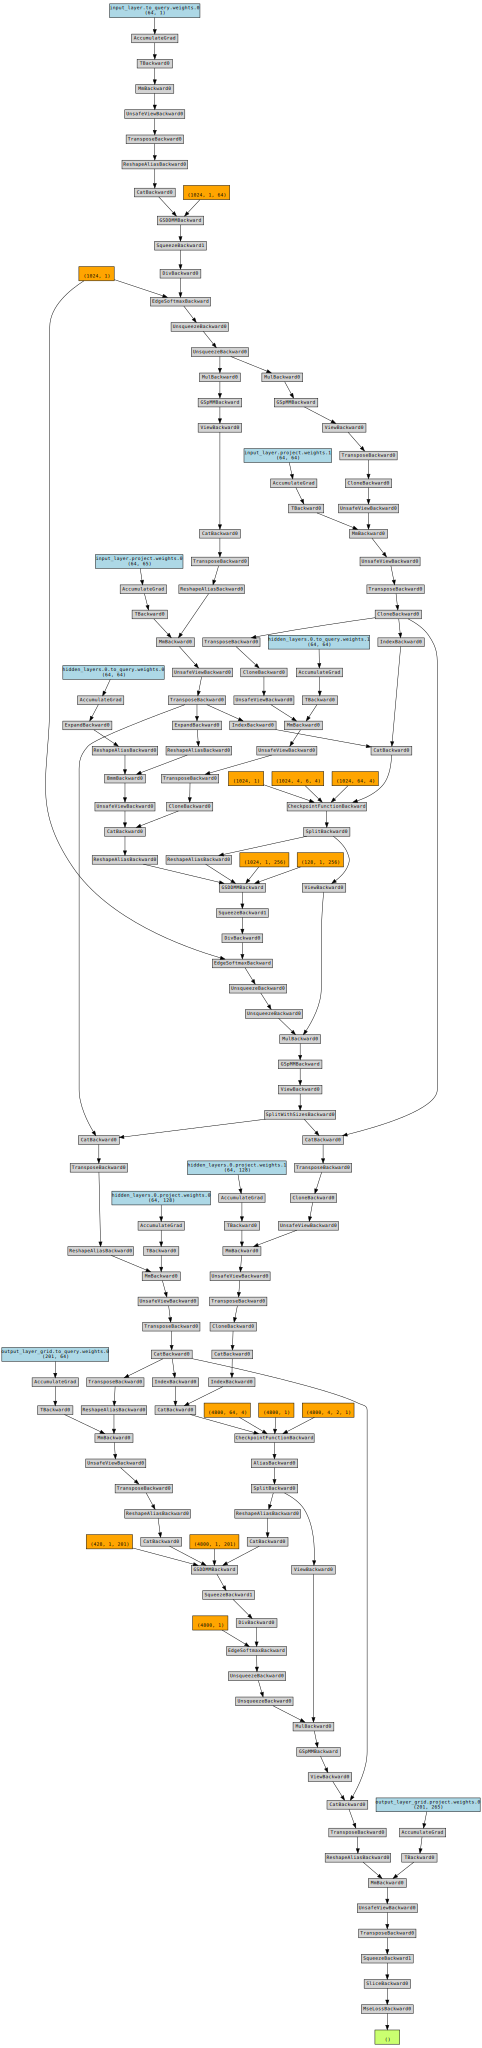

In [6]:
trainer.dots[-1]

# aten::mm takes most of the memory

In [ ]:
network = network.to('cuda')
observables_to_test = [
    "ldos",
    "band_energy",
    "band_energy_full",
    "number_of_electrons",
    "total_energy",
    "total_energy_full",
    "density",
    "dos"
]

tester = TesterGraph(parameters, network, test_data_handler,
                     observables_to_test=observables_to_test)

results = tester.test_all_snapshots()

print(results)
